>结论(只看了一个.csv 文件)：

>1：active user 约为 43%～45%

>2: 大多数人(96%)，每天收到 1～8 条 pushed messages。最多的收到过14条。可能是之前没有网，突然累计推送的。

>3: 一条新闻会推给很多人，最多的几乎全网推送，4000次。

>4: 绝大多数人(90%)，每天只会 click <=2 次，95% click <=3次。所以feature: 上次click 距现在多久，当天已经点击过多少次了。这是今天推的第几条。

In [1]:
import argparse
import logging, yaml,pandas as pd
import ujson, random, pickle
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from collections import defaultdict

# split into train and test

In [2]:
SEED = 448
random.seed(SEED)

def parse_arguments():
    parser = argparse.ArgumentParser(description='Recommendation Algo Experiments')
    parser.add_argument("-c", "--config", type=argparse.FileType(mode='r'), help="Config file")
    return parser.parse_args()

def get_news_profile_from_dairy(path):
    record = []
    with open(path, 'r') as f:
        for line in f.readlines():
            # 'news_profiles' starts at index 3
            news_profiles = " ".join(line.split()[3:])
            news_profiles = ujson.loads(news_profiles)
            record.append(news_profiles)
    return record

def train_test_split(dairy_list, ratio):
    random.shuffle(dairy_list)
    split_index = int(len(dairy_list)*ratio)
    train_dairy = dairy_list[:split_index] 
    test_dairy = dairy_list[split_index: ]
    print(len(train_dairy), len(test_dairy))
    
    return train_dairy, test_dairy

def main():
    dairy_records = get_news_profile_from_dairy("../Data/dairy_data/20181024/part-00090-8548596d-15ca-4d7e-9019-14354b9db90f.csv")
    train,test = train_test_split( dairy_records, 0.7 )
    # dump train, test
#     with open('../Data/train_dairy.txt', 'wb') as f:
#         pickle.dump(train, f)
    
#     with open('../Data/test_dairy.txt', 'wb') as f:
#         pickle.dump(test, f)
    
    print('done')
    return train, test

%time train_dairy, test_dairy = main()

(14671, 6289)
done
CPU times: user 11.9 s, sys: 2.36 s, total: 14.3 s
Wall time: 14.5 s


## check if train and test have similar feature/label distribution

In [3]:
train_dairy[0]['news_profile'].keys()

[u'61dd67ba_ci', u'9c46ceb5_ci']

In [4]:
type(train_dairy)
type(train_dairy[0])
train_dairy[0].keys()
type(train_dairy[0]['news_profile'])
train_dairy[0]['news_profile'].keys()

[u'61dd67ba_ci', u'9c46ceb5_ci']

In [5]:
def count_active_user(dairy, printInfo):
    active_count = 0
    inactive_count = 0
    for user in dairy:
        active_flag = False
        for pushed_news in user['news_profile'].keys():
            if user['news_profile'][pushed_news]['label'] == 1:
                active_count += 1
                active_flag = False
                break
        if not active_flag:
                inactive_count +=1
            
    if printInfo:
        print('active user: {} / {}, proportion = {}%'.format(active_count, active_count+inactive_count, round(active_count*100/(active_count+inactive_count), 2)))
    return active_count, inactive_count

print('train:')
train_act, train_inact = count_active_user(train_dairy, True)
print('test:')
test_act, test_inact = count_active_user(test_dairy, True)

train:
active user: 12053 / 26724, proportion = 45.0%
test:
active user: 5146 / 11435, proportion = 45.0%


>The train and test set has the same proportion of active users(clicked at least one pushed news).

>The below mainly analyze data distribution on the train set.

## check the number of clicks in active users

In [6]:
def count_num_pushed_news_pp(dairy, printInfo):
    """count number of pushed news per person"""
    pushed_counts = []
    for user in dairy:
        active_flag = False
        num = len( user['news_profile'].keys())
        pushed_counts.append(num)
    return pushed_counts

def count_num_pushed_news_pn(dairy, printInfo):
    """count number of times pushed per news"""
    pushed_news_counts = defaultdict(int)
    for user in dairy:
        active_flag = False
        for news_id in user['news_profile'].keys():
            pushed_news_counts[news_id] += 1
    
    pushed_times = [ times for news_id, times in pushed_news_counts.items() ]
        
    return pushed_times

count_pp = count_num_pushed_news_pp(train_dairy, True)
count_pn = count_num_pushed_news_pn(train_dairy, True)

In [7]:
len(count_pp)

14671

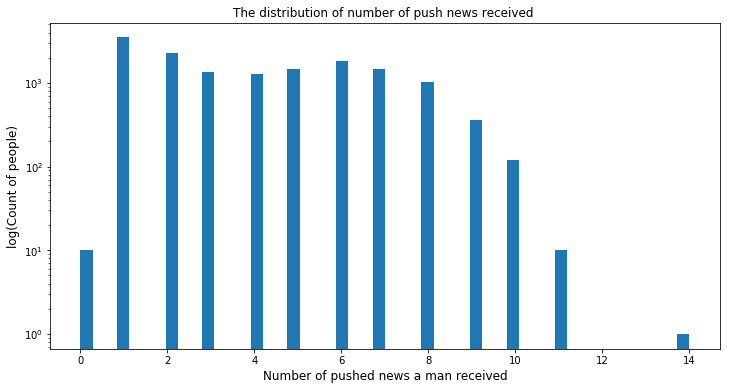

In [8]:
plt.figure(figsize = (12, 6))
plt.hist(count_pp, bins = 50, log = True)
plt.xlabel('Number of pushed news a man received', fontsize = 12)
plt.ylabel('log(Count of people)', fontsize = 12)
plt.title('The distribution of number of push news received ')
plt.show()

In [9]:
for i in range(1, 13):
    counts = [1 for p in count_pp if p < i]
    counts = round( 100.0* sum(counts)/len(count_pp),2 )
    print('People that receives push news < {}: {} %'.format(i, counts))

People that receives push news < 1: 0.07 %
People that receives push news < 2: 23.9 %
People that receives push news < 3: 39.27 %
People that receives push news < 4: 48.52 %
People that receives push news < 5: 57.21 %
People that receives push news < 6: 67.28 %
People that receives push news < 7: 79.7 %
People that receives push news < 8: 89.69 %
People that receives push news < 9: 96.63 %
People that receives push news < 10: 99.11 %
People that receives push news < 11: 99.93 %
People that receives push news < 12: 99.99 %


> 6 条以上 可能是因为server延时上报。

In [10]:
def collect_outliers(dairy, printInfo, cutoff):
    """collect users that receives too much pushed news a day"""
    outliers = []
    for user in dairy:
        active_flag = False
        num = len( user['news_profile'].keys())
        if num >= cutoff:
            outliers.append(user)
    return outliers

outliers = collect_outliers(train_dairy, True,  12)

In [11]:
len(outliers)

1

In [12]:
for o in outliers:
    print o['news_profile'].keys()

[u'6feb1b41_ng', u'248dc4a6_ng', u'9f14de7f_ng', u'a97b967c_ng', u'7eae2c22_ng', u'c1965e58_ng', u'ba8966f9_ng', u'208ed979_ng', u'7274dcc3_ng', u'4ba00307_ng', u'1391c95a_ng', u'68234ec6_ng', u'436640d3_ng', u'2cc5625e_ng']


In [13]:
user_profile = outliers[0]['user_profile'].get('nl_topic256')

for news in outliers[0]['news_profile'].keys():
    this_article = outliers[0]['news_profile'][news]
    a = this_article.get('label')
    print("label:{}".format(a))
    
    news_keywords = this_article.get('news_feature').get('topic256')
    if news_keywords:
        intersection = set(news_keywords.keys()) & set( user_profile )
        print(intersection)
        print

label:0
set([u'166', u'113'])

label:0
set([u'123', u'40'])

label:1
set([u'91', u'123'])

label:0
set([u'91', u'130', u'113', u'40'])

label:0
set([u'44', u'180', u'113'])

label:0
set([u'206', u'33', u'131', u'186', u'6', u'102', u'166'])

label:0
set([u'39', u'250'])

label:0
set([u'91', u'28'])

label:0
set([u'180', u'40'])

label:0
set([u'44', u'220'])

label:0
set([u'206', u'40', u'130', u'113', u'91', u'220'])

label:1
set([u'206', u'40', u'130', u'168', u'113', u'91'])

label:0
set([u'91', u'113', u'206'])

label:1
set([u'131', u'186', u'6'])



>仅凭这一个结果，click 看起来 不在乎权重，只在乎 user_profile 与 news_profile topic 重合个数？
可以验证一下，click的events中 user_profile 里 topic重合数，相对于 non-click 里 topic的重合数

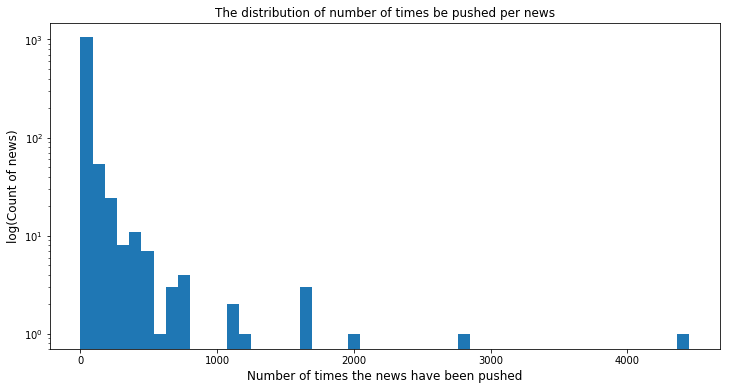

In [14]:
plt.figure(figsize = (12, 6))
plt.hist(count_pn, bins = 50, log = True)
plt.xlabel('Number of times the news have been pushed', fontsize = 12)
plt.ylabel('log(Count of news)', fontsize = 12)
plt.title('The distribution of number of times be pushed per news')
plt.show()

In [15]:
# check the most popular article:
for i in [1, 2, 5, 10, 15, 20, 50, 70, 80, 100, 150, 200, 300, 500]:
    counts = [1 for p in count_pn if p < i]
    counts = round( 100.0* sum(counts)/len(count_pn),2)
    print('News that have been pushed < {}: {}%'.format(i, counts))

News that have been pushed < 1: 0.0%
News that have been pushed < 2: 22.07%
News that have been pushed < 5: 44.48%
News that have been pushed < 10: 60.14%
News that have been pushed < 15: 68.35%
News that have been pushed < 20: 71.34%
News that have been pushed < 50: 84.17%
News that have been pushed < 70: 87.94%
News that have been pushed < 80: 88.96%
News that have been pushed < 100: 90.25%
News that have been pushed < 150: 93.16%
News that have been pushed < 200: 94.95%
News that have been pushed < 300: 96.66%
News that have been pushed < 500: 98.46%


In [16]:
# check the proportion of be clicked out of be pushed 

def count_ctr_pn(dairy, printInfo):
    """count click through rate of each news"""
    news_clicked_count = defaultdict(list)
    for user in dairy:
        active_flag = False
        for news_id in user['news_profile'].keys():
            click = user['news_profile'][news_id]['label']
            news_clicked_count[news_id].extend( [click])
    
    CTR = []
    for key in news_clicked_count.keys():
        ctr = sum( news_clicked_count[key] )/len( news_clicked_count[key] )*100
        CTR.append(ctr)
             
    return CTR

train_ctr = count_ctr_pn( train_dairy, True)

In [17]:
# check candidate pool size
len(count_pn)

1169

There are 887 unique news have been pushed.

In [18]:
counts = [1 for p in train_ctr if p == 0]
counts = round( 100.0* sum(counts)/len(train_ctr),2 )
print('News that CTR = 0: {} %'.format(counts))

News that CTR = 0: 95.81 %


Imbalance Class, 40% of active users. For each news, 4% be clicked. 

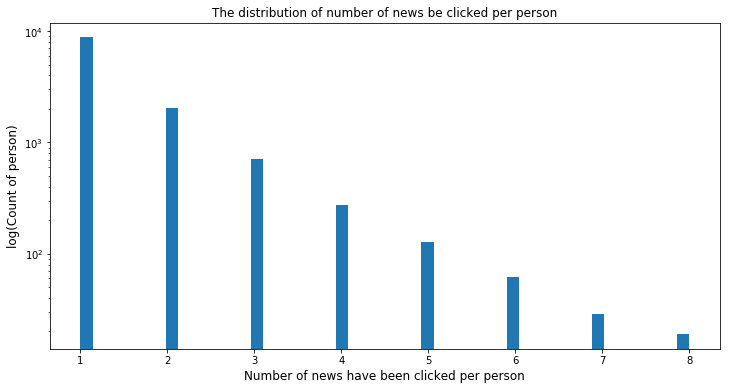

In [19]:
# check number of news be clicked per person
# def count_click_counts_pp(dairy, printInfo):
#     click_count = []
#     for user in dairy:
#         active_count = 0
#         for pushed_news in user['news_profile'].keys():
#             if user['news_profile'][pushed_news]['label'] == 1:
#                 active_count += 1
#         click_count.extend([active_count])
        
#     return click_count

def count_click_counts_pp(dairy, printInfo):
    click_count = []
    for user in dairy:
        active_count = 0
        active_flag = False
        for pushed_news in user['news_profile'].keys():
            if user['news_profile'][pushed_news]['label'] == 1:
                active_count += 1
                active_flag = True
        if active_flag:      
            click_count.extend([active_count])
        
    return click_count

click_counts = count_click_counts_pp(train_dairy, True)

plt.figure(figsize = (12, 6))
plt.hist(click_counts, bins = 50, log = True)
plt.xlabel('Number of news have been clicked per person', fontsize = 12)
plt.ylabel('log(Count of person)', fontsize = 12)
plt.title('The distribution of number of news be clicked per person')
plt.show()

# count how many active users

In [ ]:
def count_active_users(dairy, printInfo):
    click_count = []
    for user in dairy:
        active_count = 0
        active_flag = False
        for pushed_news in user['news_profile'].keys():
            if user['news_profile'][pushed_news]['label'] == 1:
                active_count += 1
                active_flag = True
        if active_flag:      
            click_count.extend([active_count])
        
    return click_count

click_counts = count_click_counts_pp(train_dairy, True)

plt.figure(figsize = (12, 6))
plt.hist(click_counts, bins = 50, log = True)
plt.xlabel('Number of news have been clicked per person', fontsize = 12)
plt.ylabel('log(Count of person)', fontsize = 12)
plt.title('The distribution of number of news be clicked per person')
plt.show()

In [20]:
for i in range(9):
    counts = [1 for p in click_counts if p <= i]
    counts = round( 100.0* sum(counts)/len(click_counts),2)
    print('Num of people that have been clicked <= {}: {}%'.format(i, counts))

Num of people that have been clicked <= 0: 0.0%
Num of people that have been clicked <= 1: 72.85%
Num of people that have been clicked <= 2: 89.82%
Num of people that have been clicked <= 3: 95.75%
Num of people that have been clicked <= 4: 98.03%
Num of people that have been clicked <= 5: 99.09%
Num of people that have been clicked <= 6: 99.6%
Num of people that have been clicked <= 7: 99.84%
Num of people that have been clicked <= 8: 100.0%


>有些人太闲了，推多少条看多少条？？是不是无论推什么，他都看。是不是应该结合推送时间看一下，他是不是每一条新闻都点啊？？如果很临近，他肯定就是太闲了

那么太闲的人的特征？手机牌子？user_profile里面权重很低？（kurtosis?）

In [201]:
# check the one that clicked too much times

def collect_ctr_outliers(dairy, printInfo, cutoff):
    outliers = []
    outliers_count = []
    for user in dairy:
        active_count = 0
        for pushed_news in user['news_profile'].keys():
            if user['news_profile'][pushed_news]['label'] == 1:
                active_count += 1
        if active_count>=cutoff:
            outliers.append(user)
            outliers_count.append(str(active_count) + str("/") + str(len(user['news_profile'].keys())))
    return outliers, outliers_count

ctr_outliers, outliers_count = collect_ctr_outliers(train_dairy, True, 4)

In [194]:
len(outliers_count)

324